In [117]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


plt.style.use('ggplot')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Competition Background 
> Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

To this end thousands of text were collated and labeled by Kaggle.  Some of them are about natural disasters while others are not.

In [118]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, label='training accuracy')
    plt.plot(x, val_acc, label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='training loss')
    plt.plot(x, val_loss, label='validation loss')
    plt.title('Loss')
    plt.legend()

In [119]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv", usecols=['target', 'text'])

df.drop_duplicates(inplace = True)


# EDA

As can be seen below there is mostly complete data.  In this analysis we ignored the keyword and the id.  Instead we will just use the text infromation and the corresponding label to train our data. Our data is roughly balanced with about 43% of the unique tweets being about disasters

In [120]:
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7521 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7521 non-null   object
 1   target  7521 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 176.3+ KB
None


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


(array([4315.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3206.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

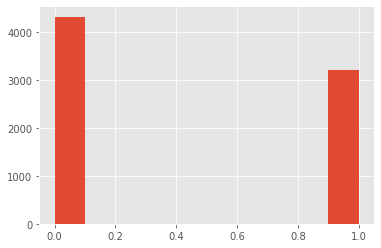

In [121]:
plt.hist(df['target'])

In [122]:
le = LabelEncoder()
le.fit(df['target'].unique())


LabelEncoder()

In [123]:
df['target_le'] = le.transform(df['target'])

In [124]:
X = df['text'].astype(str)


y = tf.keras.utils.to_categorical(df['target'], num_classes=df['target'].nunique())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['target'])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [125]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

# Tokenization:

Below is the first tweet in the training datat and the corresponding tokens

In [175]:
X_train[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [174]:
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
train_seq[0]

[5934,
 1481,
 29,
 5935,
 13,
 190,
 295,
 5936,
 844,
 3966,
 10,
 168,
 35,
 5,
 2987,
 4,
 5937,
 5938,
 13,
 5939,
 54,
 78,
 31,
 480]

In [127]:
max_length = len(max(train_seq, key=len))

train_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')
test_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

In [150]:
class StopTrainOnHighAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        acc_threshold = 0.98
        if logs.get('accuracy') > acc_threshold:
            print(f"\nReached {acc_threshold} accuracy, cancelling training")
            self.model.stop_training = True

def model(vocab_size, max_length):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])
    
    return model
    
model = model(vocab_size, max_length)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 33, 64)            1242048   
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 33, 128)           66048     
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_62 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_63 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 16)              

In [151]:
history = model.fit(train_vector, y_train, epochs=30, validation_data=(test_vector, y_test), callbacks=[StopTrainOnHighAccuracy()])

Epoch 1/30
188/188 [==============================] - 23s 92ms/step - loss: 0.6558 - accuracy: 0.5721 - val_loss: 0.5879 - val_accuracy: 0.5734
Epoch 2/30
188/188 [==============================] - 17s 89ms/step - loss: 0.5287 - accuracy: 0.8054 - val_loss: 0.5714 - val_accuracy: 0.7907
Epoch 3/30
188/188 [==============================] - 16s 86ms/step - loss: 0.4126 - accuracy: 0.8978 - val_loss: 0.6204 - val_accuracy: 0.7841
Epoch 4/30
188/188 [==============================] - 17s 92ms/step - loss: 0.3266 - accuracy: 0.9207 - val_loss: 0.7675 - val_accuracy: 0.7721
Epoch 5/30
188/188 [==============================] - 16s 86ms/step - loss: 0.2799 - accuracy: 0.9320 - val_loss: 0.9304 - val_accuracy: 0.7694
Epoch 6/30
188/188 [==============================] - 17s 89ms/step - loss: 0.2389 - accuracy: 0.9458 - val_loss: 1.1783 - val_accuracy: 0.7542
Epoch 7/30
188/188 [==============================] - 16s 84ms/step - loss: 0.2353 - accuracy: 0.9435 - val_loss: 1.0540 - val_accuracy:

In [153]:
loss, accuracy = model.evaluate(train_vector, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(test_vector, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9754
Testing Accuracy:  0.7568


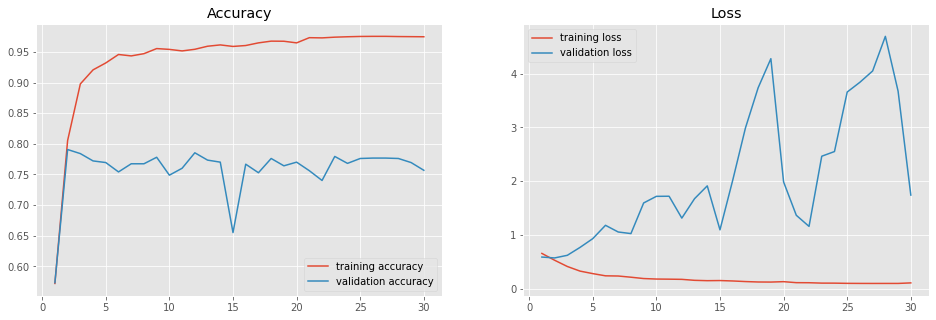

In [154]:
plot_history(history)

In [156]:

submission = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

X = submission['text'].astype(str)
final_seq = tokenizer.texts_to_sequences(X)
final_vector = tf.keras.preprocessing.sequence.pad_sequences(final_seq, maxlen=max_length, padding='post', truncating='post')


In [161]:
predict_x=model.predict(final_vector) 
classes_x = np.argmax(predict_x,axis=1)

In [164]:
preview = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
preview.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [171]:
sub = pd.DataFrame({"id": submission['id'],
                    "target": classes_x})


sub.to_csv("./submission.csv",index = False)
print(sub.columns)
sub.head(10)

Index(['id', 'target'], dtype='object')


,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
